In [ ]:
from iCLIP.random import boot_ci
import pandas as pd

# Example 3 - Enrichment in introns vs exons and single exon genes

eIF4A3 binds upstream of the exon junction. We should see more signal in exons than introns and more signal in multi-exon genes than on the single exon replication-dependent histone genes. 

`count_iclip_sites.py` allows us to count the number of crosslinks accross gene models, both introns and exons. 

In [142]:
eIF4A3_counts = pd.read_csv("eIF4A3_counts.tsv", sep="\t", comment="#")
Cntrl_counts = pd.read_csv("Cntrl_counts.tsv", sep="\t", comment="#")
# Create dataframes with the matched eIF4A4 and control counts
# (same for introns not shown)
exon_frame = pd.DataFrame({"eIF4A3":eIF4A3_counts["exon_count"],
                           "Cntrl": Cntrl_counts["exon_count"],
                           "gene_id": eIF4A3_counts["gene_id"]})
intron_frame = pd.DataFrame({"eIF4A3":eIF4A3_counts["intron_count"],
                            "Cntrl": Cntrl_counts["intron_count"]})

In [23]:
%load_ext rpy2.ipython

Enrichments could easily be strongly affected by a small number of very highly expressed or misannotated genes. We will add uncertainty to this using bootstrapping. `bootstrap` will draw random sets of genes and apply a function to them.

In [144]:
# define a function to apply to the bootstrap samples
def ratio(df):
    return df["eIF4A3"].sum()/df["Cntrl"].sum()

# exon_frame and intron_frame are pandas DataFrames contain counts
# from both eIF4A3 and the control, from count_iclip_sites

# Now take 1000 bootstrap samples from the above and apply ratio 
# to them calculate confidence intervals based on the spread of 
# these.
exon_ci = boot_ci(exon_frame, bootstraps=1000, fun=ratio)
intron_ci = boot_ci(intron_frame, bootstraps=1000, fun=ratio)

#Add the actual enrichments
exon_ci.loc["enrichment"] = ratio(exon_frame)
intron_ci.loc["enrichment"] = ratio(intron_frame)

To find if eIF4A3 also binds histone genes, get a subset of histone genes (in `histone_geneids`) and repeat the above.

In [ ]:
# Read in list of genes with only a single exon
histone_geneids = open("histone_genes").readlines()
histone_geneids = [x.strip() for x in histone_geneids]


In [122]:
# Get just contain histone genes from exon_frame
histone_counts = exon_frame[exon_frame["gene_id"].\
                            isin(histone_geneids)]

# Apply bootstrapping
histone_ci = boot_ci(histone_counts, bootstraps=1000, fun=ratio)
histone_ci.loc["enrichment"] = ratio(histone_counts)

The final results are below (plotting code not shown). You can see that while the is a strong enrichment for binding in the exons as compared to the introns, there is just as strong a binding of this EJC component on unspliced Histone genes.

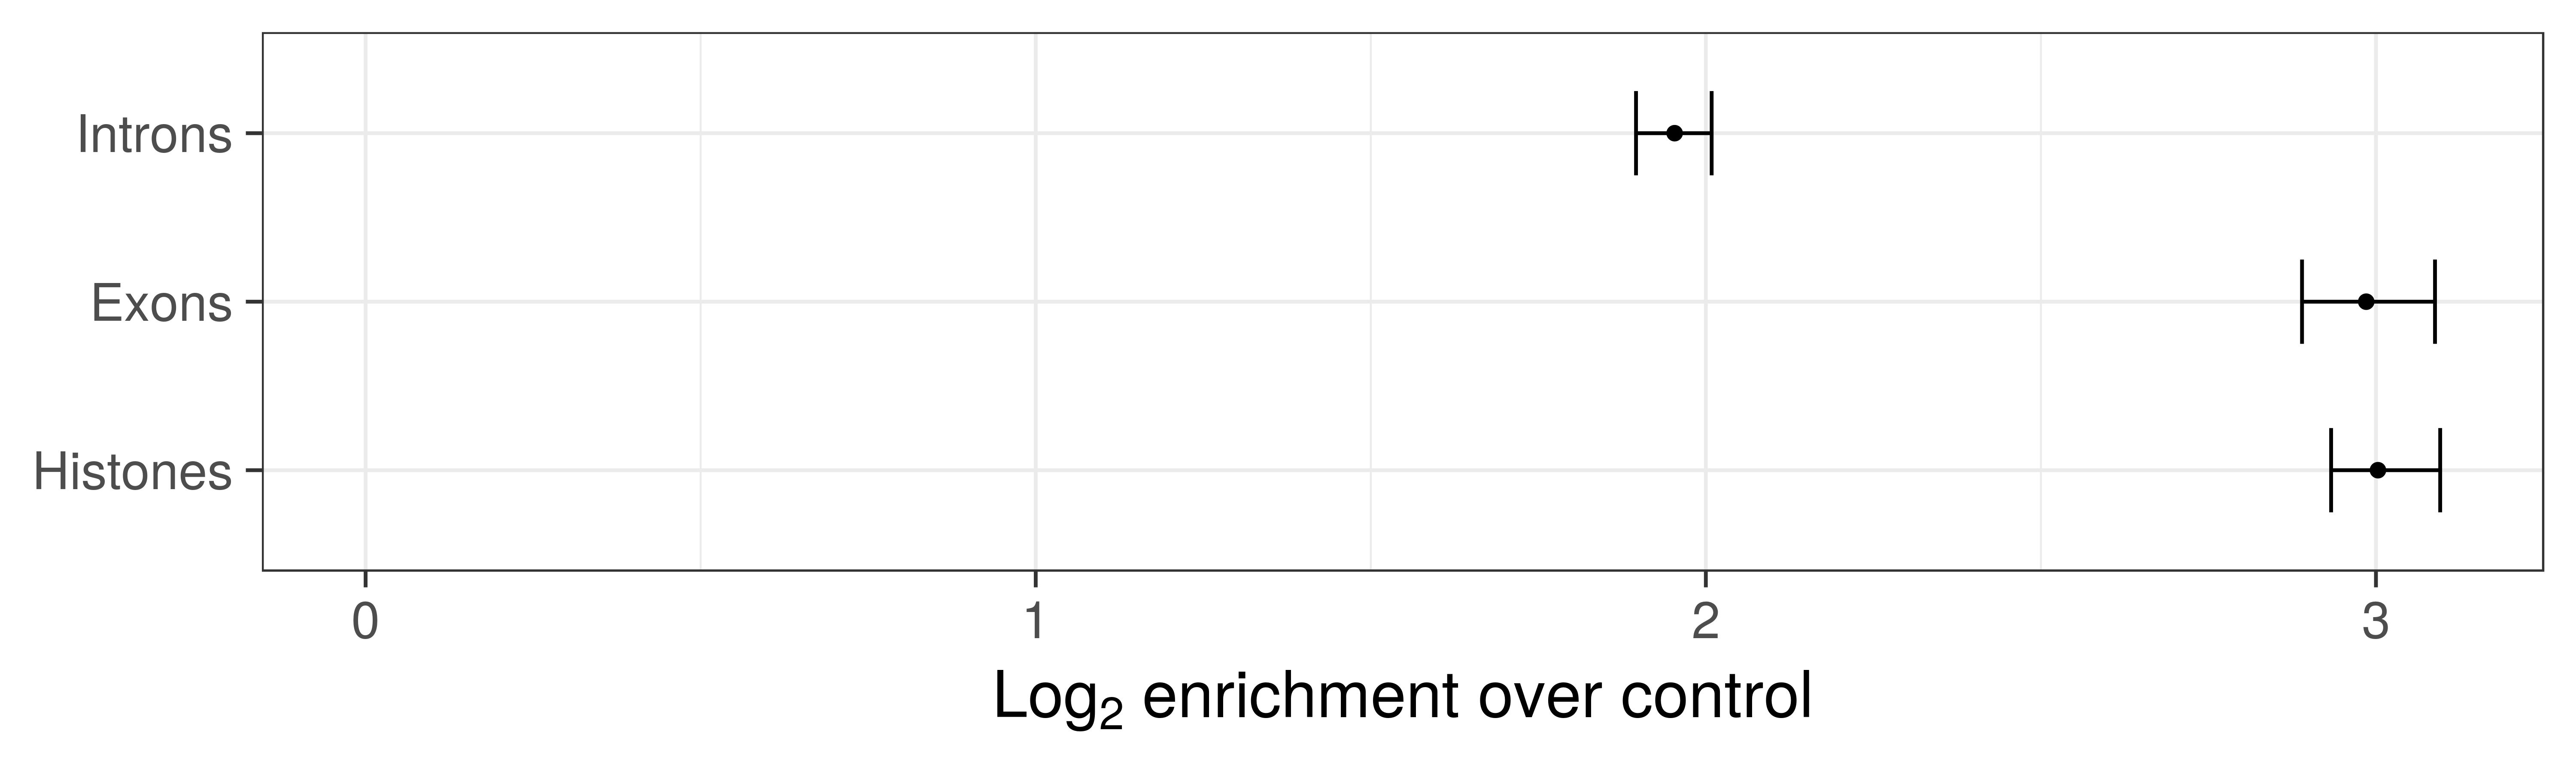

In [148]:
%%R -i exon_ci,intron_ci,histone_ci -w 10 -h 3 -u in -r 600

df <- data.frame(rbind(exon_ci,intron_ci,histone_ci), 
                 cat = factor(c("Exons", "Introns", "Histones"), 
                              ordered=TRUE, 
                              levels = c("Histones", "Exons", "Introns") ))
names(df)[1:2]= c("ymin", "ymax")
#print(df)
ggplot(df) + aes(x=cat, y=log2(enrichment), ymin=log2(ymin), ymax=log2(ymax)) +
    geom_point() +
    geom_errorbar(width=0.5) +
    theme_bw(base_size=18) +
    coord_flip() +
    ylab(expression(paste(Log[2], " enrichment over control"))) +
    ylim(c(0,NA)) +
    scale_x_discrete(name=NULL) + 
    coord_flip()